# Measurement Error Models using PyMC3

*By Herman Carstens*

# Introduction and  Motivation

In this notebook, we'll investigate the effect of measurement error on statistical inference, and how this affects energy monitoring. Acknowledgement goes to Jake van der Plas for [a blog post](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) using a similar example, as well as Thomas Wiecki (one of the PyMC3 devs) for [his blog post](https://pymc-devs.github.io/pymc3/GLM-linear/). Abraham Flaxman also answered [this](http://stackoverflow.com/questions/24804298/fit-a-non-linear-function-to-data-obs-with-pymcmc-pymc) StackOverflow question with a [notebook](http://nbviewer.ipython.org/gist/aflaxman/d4b1ce53b0817a1b7a71) that helped tremendously.

Almost all measurements have some error associated with it. While we can ignore this error in certain instances, sometimes it may be significant enough for us to have to account for it. In this notebook we will explore how measurement errors affect regression parameter estimates, and how this can be mitigated using Bayesian statistics.

First, some Python preliminaries to import the necessary libraries and tweak the notebook.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from patsy import dmatrices
from sklearn.linear_model import LinearRegression

import scipy
import scipy.stats

%matplotlib inline
sns.set

from pylab import rcParams
rcParams['figure.figsize']=18, 8 #figure sizes
rcParams.update({'font.size': 30})

## The effect of measurement error on regression estimates

To demonstrate the effect of measurement error on a regression model, we will generate some data with known characteristics, add errors to it, and see how this error affects the paramater estimates.

Suppose that we observe some phenomenon, but that our instruments with which we observe contain some error. Therefore we don't see $X_{true}$ and $Y_{true}$, but $X_{obs}$ and $Y_{obs}$. Suppose we have a very simple linear relationship

$$Y = X + 0$$

In [16]:
a=1
b=0

x_true = np.linspace(1, 1000, 100)
y_true = a*x_true+b

## Error in Y

Now suppose that we measure $Y$ with error, but $X$ without error:

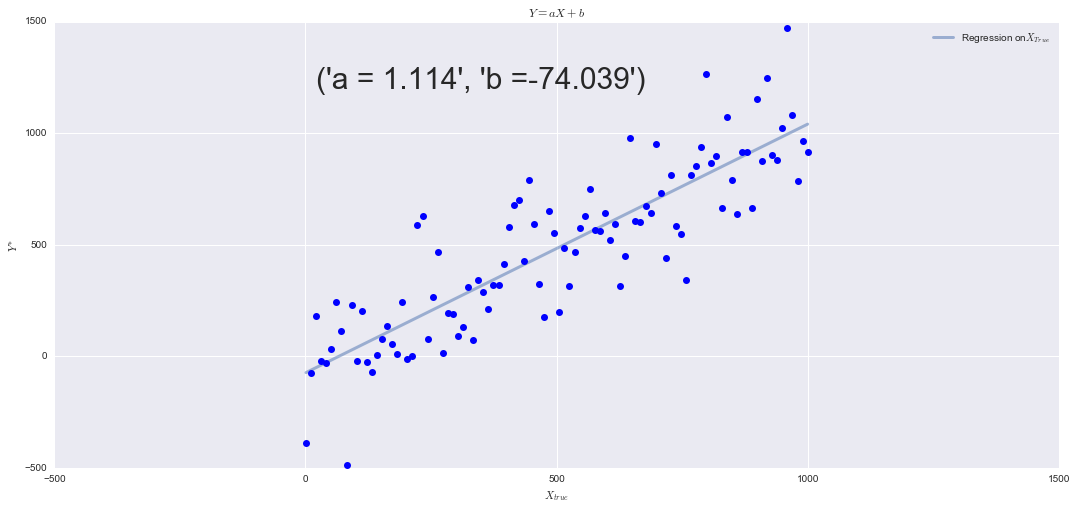

In [17]:
y_obs=np.random.normal(y_true,200)
x_obs=x_true

y_obs_LR, x_true_LR = dmatrices('y_obs~x_obs', return_type='dataframe')
est = LinearRegression()
est.fit(x_true_LR, y_obs_LR)
a_star_Y = est.coef_[0][1]
b_star_Y = est.intercept_[0]

plt.plot(x_true,a_star_Y*x_true + b_star_Y, alpha=0.5, label='Regression on' r'$X_{True}$', lw=3)
plt.plot (x_true, y_obs,'o', color='b')
plt.title(r"$Y=aX+b$")
plt.xlabel(r'$X_{true}$')
plt.ylabel(r'$Y^{*}$')
plt.legend()
plt.axis([-500, 1500, -500, 1500])
note = 'a = {:.3f}'.format(a_star_Y), 'b ={:.3f}'.format(b_star_Y)
plt.annotate(note, xy=(20,1200))

The error doesn't have a big impact on how the data is scattered. We can still draw a reasonable straight line through it. Now, let us add an error to $X$:

## Error in X

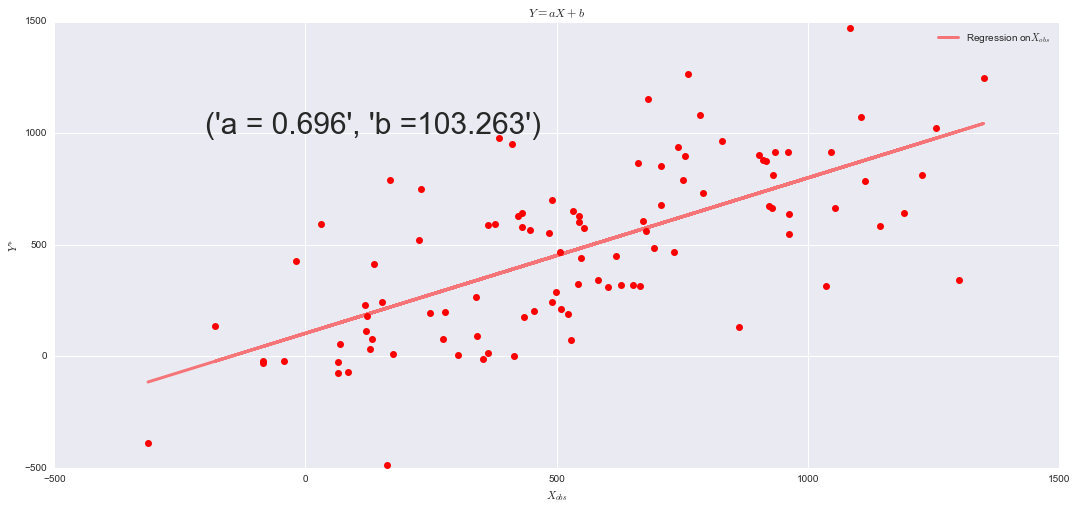

In [18]:
x_obs=np.random.normal(x_true, 200)

y_obs_LR, x_obs_LR = dmatrices('y_obs~x_obs', return_type='dataframe')
est = LinearRegression()
est.fit(x_obs_LR, y_obs_LR)
a_star_X = est.coef_[0][1]
b_star_X = est.intercept_[0]

plt.plot(x_obs,a_star_X*x_obs + b_star_X, alpha=0.5, label='Regression on' r'$X_{obs}$', lw=3, color='r')
plt.plot (x_obs, y_obs,'o', color='r')
plt.title(r"$Y=aX+b$")
plt.xlabel(r'$X_{obs}$')
plt.ylabel(r'$Y^{*}$')
plt.legend()
plt.axis([-500,1500,-500,1500])
note = 'a = {:.3f}'.format(a_star_X), 'b ={:.3f}'.format(b_star_X)
plt.annotate(note, xy=(-200,1000))

If we look at the the parameter estimates for $a$ and $b$, we see that they are far from the true values. The scatter does not only add uncertainty, but actually *changes* the parameter estimates, by biasing the slope towards zero. In the graph above, notice how it is a 'flattened out' version of first one: the y-axis values are the same, but the x-axis' maximum value has stretched form 1000 to 1200. 

To illustrate the effect on the same graph, let us plot the following:

Erroneous Regression parameters:  0.7 	 103.3
True Regression parameters:       1.1 	 -74.0


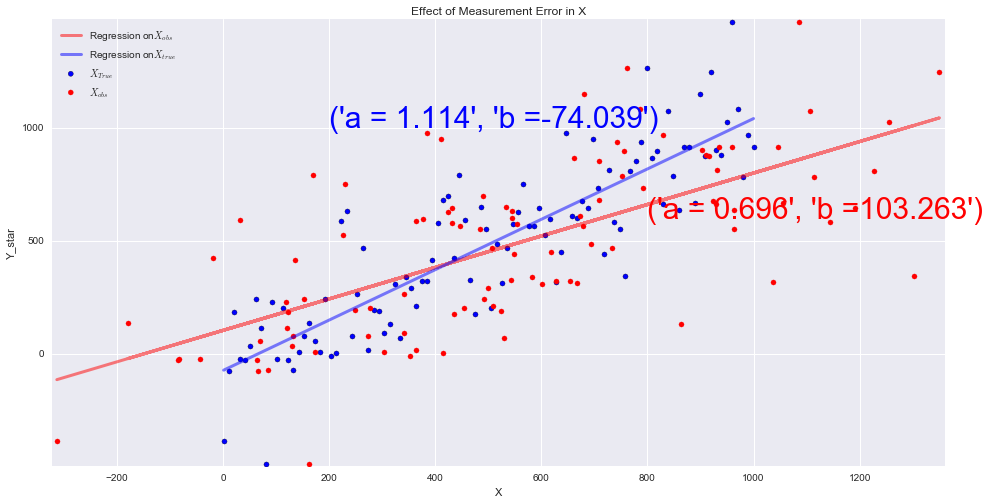

In [19]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, xlabel='X', ylabel='Y_star', 
                     title='Effect of Measurement Error in X', 
                     xlim=(np.int(x_obs.min())-10, np.int(x_obs.max())+10),
                     ylim=(np.int(y_obs.min())-10, np.int(y_obs.max())+10))

ax.scatter(x_true, y_obs, c='b',s=26, label=r'$X_{True}$')
ax.scatter(x_obs, y_obs, s=26, label=r'$X_{obs}$', color = 'r')

ax.plot(x_obs,a_star_X*x_obs + b_star_X, c='r', alpha=0.5, label='Regression on' r'$X_{obs}$', lw=3)
ax.plot(x_true, a_star_Y*x_true + b_star_Y, alpha=0.5, c='b', label='Regression on' r'$X_{true}$', lw=3)
ax.legend(loc='upper left');
note = 'a = {:.3f}'.format(a_star_X), 'b ={:.3f}'.format(b_star_X)
plt.annotate(note, xy=(800, 600), color='r')
note = 'a = {:.3f}'.format(a_star_Y), 'b ={:.3f}'.format(b_star_Y)
plt.annotate(note, xy=(200,1000), color='b')
print('Erroneous Regression parameters: ', "{:.1f}".format(a_star_X), "\t {:.1f}".format(b_star_X))
print('True Regression parameters:      ', "{:.1f}".format(a_star_Y), '\t',"{:.1f}".format(b_star_Y))

## Attenuation

Attenuation is the term describing how errors in $X$ bias the paramter estimates. which we can see in the plot below, as shown in [Gustafson](https://www.crcpress.com/Measurement-Error-and-Misclassification-in-Statistics-and-Epidemiology/Gustafson/9781584883357). Attenuation is when the estimate on the slope parameter in a linear regression model is reduced because of error in the measurement of the independent variable $X$. The attenuation factor can be defined as:

$$\frac{\theta_{1}^{*}}{\theta_{1}}=\frac{1}{1+\tau^{2}},$$

where $\tau^{2}$ is the error term such that $(X^{*}\mid X,Y)\sim N(X,\tau^{2}\sigma^{2})$$  

Errors in measuring $Y$ does increase uncertainty in $Y$ as the error increases, but do not bias parameter estimates. Below we plot the parameter estimates of the regression model above, versus the size of the error ($\tau$).

In the case below, we do a linear regression on:

$Y_{obs} = aX_{obs}+b$

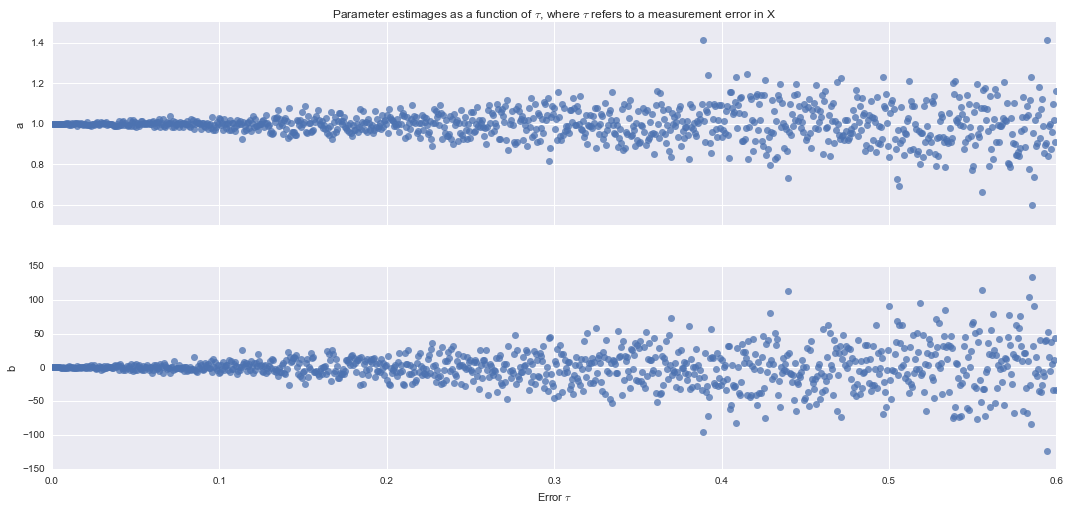

In [20]:
k = 0
tau = np.linspace(0.0001, 0.6, 1000)
a_star = np.zeros(len(tau))
b_star = np.zeros(len(tau))
a=1
b=0
x_obs=x_true

for i in range(len(tau)):
    #y_obs = (a*x_true + b)/np.random.normal(np.ones_like(y_true), tau[i]) #I think that this method is incorrect
    y_obs = np.random.normal((a*x_true + b), (a*x_true + b)*tau[i])
    y_obs_LR, x_obs_LR = dmatrices('y_obs~x_obs', return_type='dataframe')
    est = LinearRegression()
    est.fit(x_obs_LR, y_obs_LR)
    a_star[i] = est.coef_[0][1]
    b_star[i] = est.intercept_[0]
    k = k + 1
    
y_star = np.random.normal(y_true, 20) #reset y_star

f,axarr = plt.subplots(2, sharex=True)
axarr[0].plot(tau, a_star, 'o', alpha=0.75) 
axarr[0].set_title('Parameter estimages as a function of ' r'$\tau$, where ' r'$\tau$'
                   ' refers to a measurement error in X')
axarr[1].set_xlabel(r'Error $\tau$')
axarr[0].set_ylabel('a')
axarr[1].plot(tau, b_star, 'o', alpha=0.75)
axarr[1].set_ylabel('b')

In the graph above, **ideally, we want a straight, horizontal line at 0 for $a$ and 1 for $b$**. We can see that as the error increases, our uncertainty about the parameter estimates increase. However, the mean parameter estimate remains unbiased.

For the simulation below we do the same, but with error in $X$. We observe and regress against $X_{obs}$, which is $X_{true}$ measured with error:

$$X_{obs} \sim N(X_{true},\ \tau^{2})\  \forall \  tau \  \in (0,0.6)$$

although $Y_{obs}$ is determined by the true values of $X$:

$$Y_{true} = Y_{obs} = aX_{true}+b$$

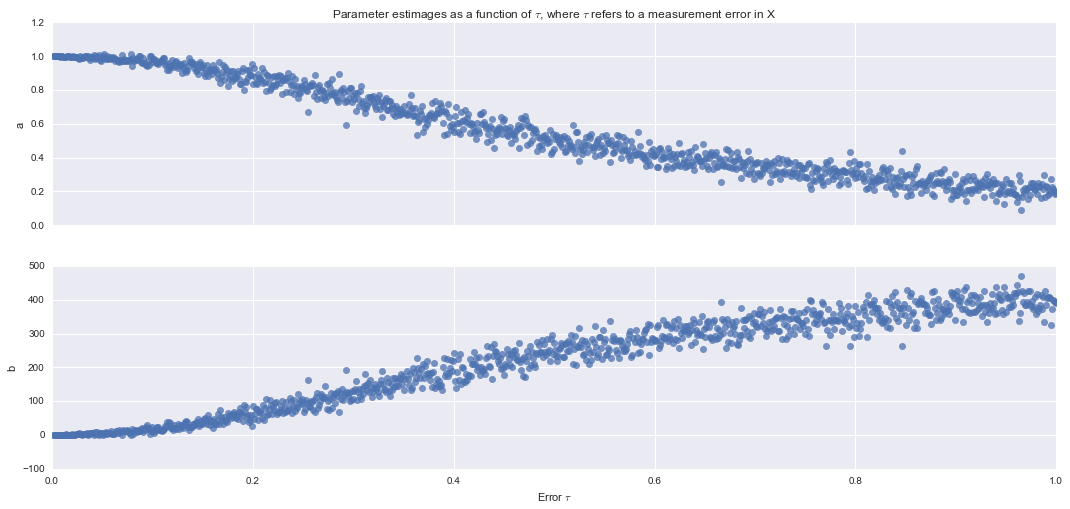

In [21]:
k = 0
tau = np.linspace(0.001, 1, 1000)
a_star = np.zeros(len(tau))
b_star = np.zeros(len(tau))

for i in range(len(tau)):
    #x_obs = x_true/np.random.normal(np.ones_like(x_true), tau[i]) #I think that this is incorrect.
    x_obs = np.random.normal(x_true, x_true*tau[i])

    y_obs = a*x_true + b
    y_obs_LR, x_obs_LR = dmatrices('y_obs~x_obs', return_type='dataframe')
    est = LinearRegression()
    est.fit(x_obs_LR, y_obs_LR)
    a_star[k] = est.coef_[0][1]
    b_star[k] = est.intercept_[0]
    k=k+1
    
f,axarr = plt.subplots(2, sharex=True)
axarr[0].plot(tau, a_star, 'o', alpha=0.75) 
axarr[0].set_title('Parameter estimages as a function of ' r'$\tau$, where ' r'$\tau$'
                   ' refers to a measurement error in X')
axarr[1].set_xlabel(r'Error $\tau$')
axarr[0].set_ylabel('a')
axarr[1].plot(tau, b_star, 'o', alpha=0.75)
axarr[1].set_ylabel('b')

From the graph above it is clear that as $\tau$ increases, the estimate for $\theta_{1}$ decreases, although our uncertainty does not. As a result of this, the estimate for the y-intercept $\theta_{0}$ increases. In other words, measurement error in $X$ *biases* our parameter estimates.

# A Potential Solution

In the real world, we have no access to the true parameters - all we have are the noisy $X^{*}$ and $Y^{*}$ measurements. And so we may know that our parameter estimates are biased, but we don't know by how much. In more complex regression cases, we wouldn't even know in which direction this bias manifests.

Regression on errors-in-measurements data has been a particularly difficult problem to solve in frequentist statistics, as shown by [Jaynes](http://exordio.qfb.umich.mx/archivos%20pdf%20de%20trabajo%20umsnh/aphilosofia/bayesian%20importantes/leapz.pdf). [Carrol et al.](http://www.stat.tamu.edu/~carroll/eiv.SecondEdition/) have written an excellent textbook on modern frequentist methods, and [Gustafson](https://www.crcpress.com/Measurement-Error-and-Misclassification-in-Statistics-and-Epidemiology/Gustafson/9781584883357) gives a good appraisal of these methods. The approach adopted below relies on Bayes Markov Chain Monte Carlo (MCMC) implemented via PyMC3.

A brief note on frequentist vs. Bayesian regression. In frequentist regression, we see write the linear regression equation as:

$$Y=X\theta+\epsilon,$$

whereas in a Baysian framework, we acknowledge the uncertainty in $Y$ by writing the regression equation as

$$Y \backsim N(X\theta,\sigma^{2}).$$

In the figures below, I have implemented a Bayesian solution alongside an OLS solution. The code is in an appendix at the bottom of the notebook as it is a batch process that can take very long to run. We see the classic bias effect in the OLS solution as above. The Bayesian solution is also affected by the error in $X$, but not nearly as much as the OLS solution.

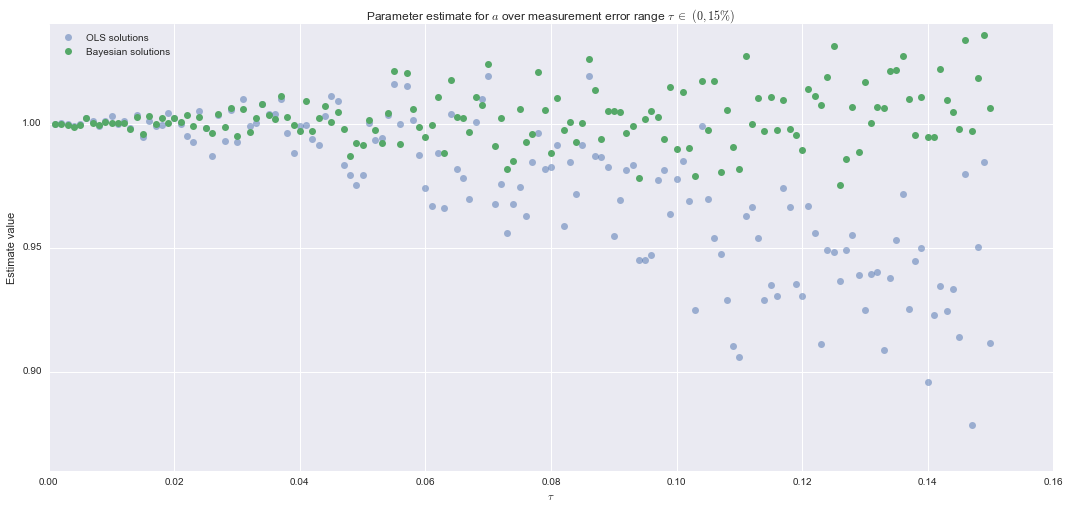

In [22]:
LinReg = pd.read_csv('LinReg_results.csv')

plt.plot(LinReg.tau, LinReg.a_star, 'o', alpha=0.5, label='OLS solutions')
plt.plot(LinReg.tau, LinReg.a_Bayes, 'o', alpha=1, label='Bayesian solutions')

plt.legend(loc='best')
plt.ylabel('Estimate value')
plt.xlabel(r'$\tau$')
plt.title(r'Parameter estimate for $a$ over measurement error range $\tau\ \in\ (0,15\%)$')

Doing these runs can be quite expensive, and so I've stopped the batch much earlier than $\tau=0.5$. If my machine has capacity, I will complete them at a later date. However, the trend is clear. The Bayesian solution is less biased at higher values of $\tau$, although it does become more dispersed. Below we plot the distributions on the Bayesian and OLS solutions to make the characteristics clearer:

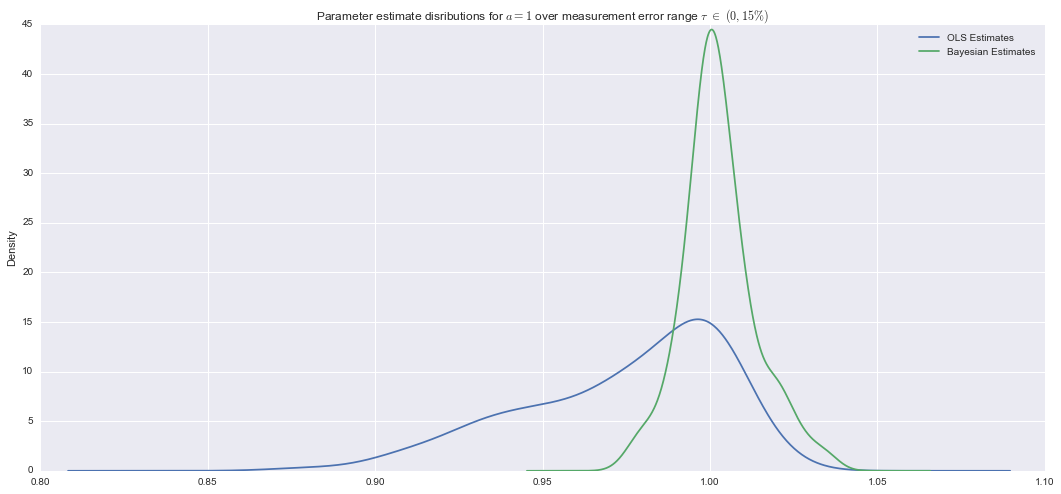

In [23]:
LinReg[0:np.where(LinReg.a_star.isnull())[0][0]].a_star.plot(kind='kde', label='OLS Estimates')
LinReg[0:np.where(LinReg.a_star.isnull())[0][0]].a_Bayes.plot(kind='kde',label='Bayesian Estimates')
plt.title(r'Parameter estimate disributions for $a=1$ over measurement error range $\tau\ \in\ (0,15\%)$')
plt.legend()

Above we see that the Bayesian estimate for hits $a=1$ (the correct value) much more often over the error range than the OLS solution. Of course, close to $\tau=0$ both are centered around 1, but as the error increases, so does the left tail of the OLS distribution.


We do the same for the $b$ parameter:

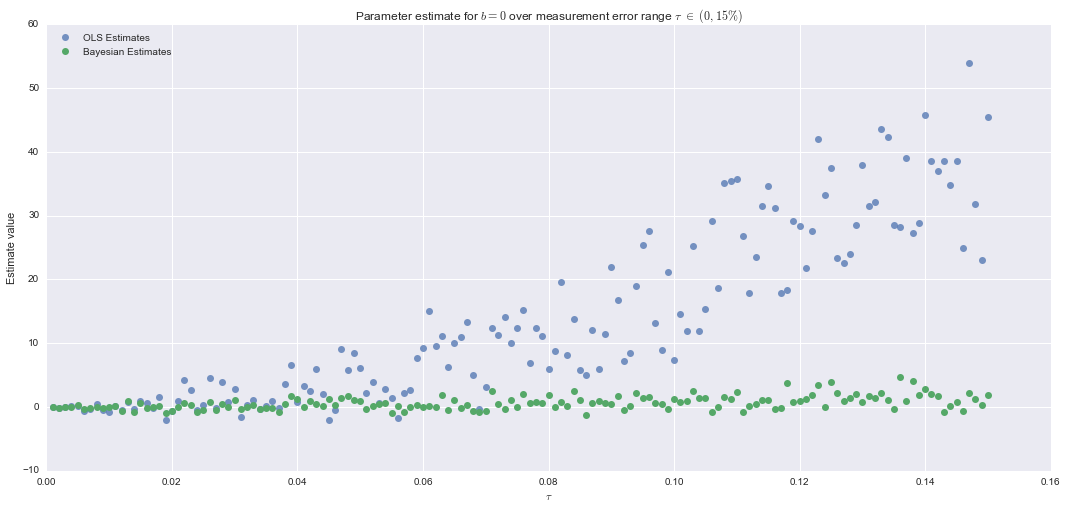

In [24]:
plt.plot(LinReg.tau,LinReg.b_star, 'o', alpha=0.75, label = 'OLS Estimates')
plt.plot(LinReg.tau,LinReg.b_Bayes, 'o', label = 'Bayesian Estimates')

plt.legend(loc=2)
plt.ylabel('Estimate value')
plt.xlabel(r'$\tau$')
plt.title(r'Parameter estimate for $b=0$ over measurement error range $\tau\ \in\ (0,15\%)$')

In this case it is not necessary to plot the comparative distributions, as the Bayesian estimate is clearly superior and holds to $b=0$ remarkably well.

# Application

<img src="energy_logger.jpg", style="width: 300px">


Suppose that we want to calibrate an electrical energy meter using a power supply and second energy meter with a known error. Let $X$ be the true values, $X^{*}$ be the values measured by the calibrator, and $Y^{*}$ be the values measured by the Unit Under Test (UUT). So both the UUT and calibrator receive $X$ as an input, but this is changed to, and displayed as $X^{*}$ and $Y^{*}$ according to their internal errors.

In a perfect world without errors,

$$Y = X = Y^{*} = X^{*}.$$

If we regress $Y^{*}$ against $X^{*}$, pretending that there are no errors in the independent variable, i.e. $X^{*}=X$, then the $Y^{*}$ parameters will be attenuated with respect to $X$ (the true values). This is called naïve estimation, and the calibration will be biased. We want to get as close to $Y$ as possible, and so we have to take the error of $X^{*}$ into consideration in the mathematics.

We should note here that identifying these errors in electrical measurements has certain challenges. First, instruments are generally very accurate, and so the errors may be small. Second, methods such as those proposed by [Gustafson](https://www.crcpress.com/Measurement-Error-and-Misclassification-in-Statistics-and-Epidemiology/Gustafson/9781584883357) are not applicable for the experiment at hand: if we could do gold-standard measurements, we would use the gold standard instrument as a calibrator, and not be concerned with errors in $X$. Of course, this is different for medical studies where it may be practical to do comprehensive, gold-standard testing on only a few patients. On the other hand, we can specify well-known structural models for electrical measurements that would not be available in medical studies. It is this strength that we will exploit below.

## Calibrator Error

Energy meter accuracy is usually specified by their 'Class' designation, as a precision value: $p = 0.5\%, 1\%, 2\%$, etc. This refers to the $95%$ confidence interval limit: it may be at $1.005\mu, 1.01\mu, 1.2\mu$, etc. Notice that this is then a multiplicative error: $X^{*} = X(1+p)$, where $p$ is the precision value. We are going to assume that this is the only information we have about $X^{*}$, and that we have a $10\%$ error at the $95\%$ confidence level. This is quite a big error for an electrical instrument, but notice that from the linear regression graphs above, for $p=10\%$ and $z=1.96$, we effectively have a case of $\tau=5\%$. Even though the Bayesian method is clearly superior over the whole range, its advantage at smaller $\tau$ values is less pronounced.


## UUT Error

For the UUT we can specify a more detailed model, as presented by [Carobbi et al.](http://www.imeko2009.it.pt/Papers/FP_405.pdf):

$$Y^{*} = (1+\alpha)Xcos(\phi+\phi_{c})+\epsilon,$$

where $\alpha$ is the gain error, $\phi_{c}$ the phase error, and $\epsilon$ the bias error. As mentioned above, though, when we do the regression, we only have access to $X^{*}$. What we see when we measure with the UUT is

$$Y^{*} = (1+\alpha)X^{*}cos(\phi+\phi_{c})+\epsilon.$$

Our question, then, is: can we identify $\alpha, \phi_{c},\text{ and } \epsilon$?

**Small digression: Multiplicative errors and frequentist analysis:** It is worth noting at this point that the error in the calibrator is multiplicative, not additive. This means that the data are [*heteroscedastic*](https://en.wikipedia.org/wiki/Heteroscedasticity): the variance around each data point is a function of its value: the larger the value, the larger the variance. In frequentist regression analysis, this is where the wheels come off. We need the variance on the data to be the same for all data points for the maths to work. In order keep using standard frequentist regression techniques, you have to regress against $logX^{*}$ (So that you get $logX^{*} = logX + log\epsilon$ and are back in additive mode), and then work with lognormal distributions, etc. It can be done for some cases, but it is by no means pretty. It also becomes difficult with non-linear terms such as the $cos(\phi + \phi_{c})$ that we have. A far more elegant solution, to my mind, is using a Bayesian statistical model, as will be demonstrated below.

## Modelling the calibration

We now have the mathematical framework with which to model the calibration process and can move on to modelling this in software. I'm using [PyMC3](https://github.com/pymc-devs/pymc3), an open-source Bayesian MCMC library implemented in Python.

First, we need to define the parameters with which we will generate the synthetic data set. We need to use a synthetic data set rather than a real one so that we have access to the true values for error calculation purposes. I have specified a $10\%$ error on the gain, and a $0.2$ radian ($11.46^{\text{o}})$ error on the phase. To make things slightly more interesting, I have allowed $\epsilon$ to be normally distributed, rather than have a constant value. It has a mean of 5.

In [25]:
# Preliminaries
from pymc3 import *
import theano.tensor as T
theano.config.exception_verbosity = 'high' # for handling theano errors more accurately

# Parameter definitions
GAIN_ERROR = 0.2
PHASE_ERROR = 0.2
BIAS_ERROR_MEAN = 5
BIAS_ERROR_SD = BIAS_ERROR_MEAN*0.5
X_PRECISION = 0.1 # precision of calibrator at 95% confidence level
X_CONF = 1.96 # z = 1.96 is the 95% confidence level.

To simplify some code later on, I define a function to take care of converting the true input of the UUT, $X$, to the output $Y^{*}$:

In [26]:
def x_to_y_star(x, yg, yp, ybm, ybsd, phi):
    # generate individual bias errors for every point of x, according to the
    # normal distribution with parameters ybm and ybsd
    return ((1 + yg)*x*np.cos(yp+phi) + np.random.normal(loc=ybm, scale=ybsd, size=x.size))

Next, we generate the data. Note that the experiment measures values between zero and a thousand, repeated at three levels of the [Power Factor](https://en.wikipedia.org/wiki/Power_factor) (PF). I have worked in radians (i.e., specifying $\phi$), and not PF itself, where $PF=cos\phi$. The experiment is this repeated for $\phi = \{\frac{\pi}{3},\frac{\pi}{6},0\}$. Not only does this simplify the code, but it is also the preferable way to specificy non-informative priors later on, as shown by [van der Plas](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/).

In [27]:
testpoints = pd.Series(np.arange(5, 1005, 100))  # Testpoints are the
# points at which readings are taken, i.e. where the calibrator
# is set to 5, 10, 15...
phipoints_ones = pd.Series(np.ones_like(testpoints))
x_star_arr = pd.concat([testpoints, testpoints, testpoints],
                       ignore_index=True)

x = np.random.normal(x_star_arr, x_star_arr*X_PRECISION/X_CONF)
phi_v = pd.concat([np.pi/3*phipoints_ones, np.pi/6*phipoints_ones,
                   0*phipoints_ones], ignore_index=True)
y_star = x_to_y_star(x, GAIN_ERROR, PHASE_ERROR,
                     BIAS_ERROR_MEAN, BIAS_ERROR_SD, phi_v)

obs = pd.DataFrame({'x_star':x_star_arr, 'phi':phi_v, 'y_star':y_star,
                    'x':x})

## Estimation methods

From the definitions above, we know that the true parameters with which the data were generated, are:

$\alpha = 0.2$

$\phi_{c} = 0.2$

$\epsilon = 5$.

A good model would be one that eliminates us much bias as possible, and thus estimates the parameters as closely as possible. Second, a good model should fit the data well on a graph. This is not always the same thing, as one paramater estmiate may be 'high' and another 'low', but the fit on the graph still acceptable.

A simple, accurate way to establish this baseline is to fit a line that minimises the absolute error, for a minimum absolute error (MAE) fit. The absolute error is preferred over the least squares error because it doesn't place as much weight on the higher values the way OLS does. This problem is compounded in our case because our errors are multiplicative: larger variance on larger values. In order to reduce the attenuation affect even more, errors are divided by their corresponding $X$ value, yielding a Weighted Minimum Absolute Error (WMAE):

$$WMAE = \text{min}\Sigma_{i=1}^{n} \frac{\mid Y^{*}_{i}-(1+\alpha)X_{i}cos(\phi+\phi_{c})+\epsilon)\mid}{X_{i}}.$$

Four models have been selected for comparison:

1. A naïve WMAE model, as described above, but where $X^{*}$ instead of $X$ is used.
2. OLS regression
3. A Bayesian model with a Normal priors on $X$, the parameters, and the likelihood function of $Y^{*}$

### 1. Minimum Absolute Error Estimation

In [28]:
#Function for sum(|y*-y*(X*)| / X*)
def WMAE(params):
    [yg,yp,yb]=[params[0], params[1], params[2]]
    return np.sum((np.abs(obs.y_star-((1 + yg)*obs.x_star*np.cos(yp+obs.phi) + yb)))/(obs.x_star))

res_WMAE = scipy.optimize.minimize(WMAE, np.array([0.0, 0.0, 0.0]),method='Powell')
print(res_WMAE.message)
print()
print('gain error: \t', "{:.3f}".format(res_WMAE.x[0]))
print('phase error: \t', "{:.3f}".format(res_WMAE.x[1]))
print('bias error: \t', "{:.3f}".format(res_WMAE.x[2]))

Optimization terminated successfully.

gain error: 	 0.167
phase error: 	 0.181
bias error: 	 5.549


### 2. Ordinary Least Squares

In [29]:
def OLS(params):
    [yg, yp, yb]=[params[0], params[1], params[2]]
    return np.sum((obs.y_star-((1 + yg)*obs.x_star*np.cos(yp+obs.phi) + yb))**2)

res_OLS = scipy.optimize.minimize(OLS, np.array([0.0, 0.0, 0.0]), method='Powell')
print(res_OLS.message)
print()
print('gain error: \t', "{:.3f}".format(res_OLS.x[0]))
print('phase error: \t', "{:.3f}".format(res_OLS.x[1]))
print('bias error: \t', "{:.3f}".format(res_OLS.x[2]))

Optimization terminated successfully.

gain error: 	 0.188
phase error: 	 0.196
bias error: 	 2.230



### 3. Bayesian Model specification

In a Bayesian model we have to define priors. These are distributions which include the prior information we have about the process, excluding that which came from the data itself. In our case, we have some prior information about the gain, phase, and bias errors, as well as about the error in $X$.

#### Priors

We specify vague priors around the WMAE estimates:

$$P(\alpha) \sim StudentT(\mu=\hat\alpha_{WMAE},\ \sigma=2.5,\ \nu=1).$$

$$P(\phi_{c}) \sim StudentT(\mu=\hat\phi_{WMAE},\ \sigma=2.5,\ \nu=1).$$

$$P(\epsilon) \sim StudentT(\mu = \hat\epsilon_{WMAE},\ \sigma=2.5,\ \nu=1).$$

We specify a prior on the calibrator error. We can safely assume a normal distribution according to the 10% precision at 95% confidence specification.

$$P(X) \sim Normal\left(X^{*},\ X^{*}\frac{p}{z}\right)\sim Normal\left(X^{*},\ X^{*}\frac{0.01}{1.96}\right)$$

These distributions are heteroscedastic, as we need them to be. Therefore we can include into our prior belief that $\textrm{VAR}(X_{1}=1) \ll \textrm{VAR}(X_{n}=1000)$. Because we sample using an MCMC technique, the various combinations of $X$ values will be represented in proportion to their probabilities. The plot below illustrates how the algorithm models these variances (note this is only an example):

<img src="x_prior_trace.png", style="width: 1000px">

Looking at it a different way, we know $P(X^{*}|X)$, and $P(X)$. The MCMC algorithm uses this, by Bayes' Theorem, to produce $P(X|X^{*})$ - a distribution we would not normally have access to, but which we do need if we want to avoid attentuation.


#### Likelihood

Since we are writing a probabilistic program, we replace the parameters with the prior distributions we just specified. In a standard regression where are points are weighted equally, the likelihood function would be:


$$P(Y^{*}\rvert X^{*}) \sim StudentT\left(\mu=\bigl(1+P(\alpha)\bigr) P(X)cos\bigl( \phi+P(\phi_{c})\bigr) +P(\epsilon),\  \sigma=5,\ \nu=1\right)$$.

I should note that for a reason I don't understand, we obtain better results using $\sigma=5$. At the moment, this is ad hoc.

We can now write the likelihood function for $Y$ as $P(Y\rvert X^{*},Y^{*})$, where we simply specify that it is a likelihood function by adding the term 

`observed=obs.y_star` 

to the parameters passed for 

`pymc3.StudentT()`.

**Digression:** At this point I have wondered, why not specify the WMAE function as the likelihood for $\mu$, with `observed=0`? The answer, I think, is that doing this would be to use the MCMC as an optimisation algorithm, which it is not. The Powell (modified Simplex) algorithm used to find the WMAE estimates is much more efficient than MCMC at doing that. The Bayesian approach is entirely different. First, we simulate $X\sim Normal(X^{*},\sigma)$, so that the regressor vector in our MCMC runs approximates the distribution on $X$. The WMAE is simply weighting errors blindly. Second, the answers we obtain are not just point estimates, but distributions, given the data observed for $Y^{*}$.

#### MCMC

Since only continuous distributions were specified, the No U-Turn Sampler (NUTS) is used. This is our current state of the art Hamiltonian Monte Carlo algorithm using adjustable step sizes. The Powell-WMAE parameter estimates are used as the starting point for NUTS and the means for the priors. Since many variables are specified (specifically owing to the prior on $X$), many samples are needed.

In [30]:
shape = obs.x_star.size
sd_y = 5 #Found to work through trial and error
sd_x = (obs.x_star*(X_PRECISION/X_CONF)).as_matrix()
obs_x = x_star_arr.as_matrix()

with Model() as model:

        gain_error = StudentT('gain_error', mu=res_WMAE.x[0], sd=2.5, nu=1)
        phase_error = StudentT('phase_error', mu=res_WMAE.x[1], sd=2.5, nu=1)
        bias_error = StudentT('bias_error', mu=res_WMAE.x[2], sd=5, nu=1)
        x_prior = Normal('x_prior',
                         mu=obs_x,
                         sd=sd_x,
                         shape=shape)
                         
        mu_y = (1 + gain_error)*x_prior*T.cos(phase_error + obs.phi) + bias_error
        
        y_likelihood = StudentT('y_est',
                                nu=1,
                                mu=mu_y,
                                sd=sd_y,
                                shape=shape,
                                observed=obs.y_star)
        
        start={'gain_error': res_WMAE.x[0], 'phase_error': res_WMAE.x[1], 'bias_error': res_WMAE.x[2],
               'x_prior': obs.x_star}

        trace = sample(40000, step=NUTS(), start=start)


hist = pd.DataFrame()
Bayes=np.array([np.nan, np.nan, np.nan])
hist['index'] = pd.Series(np.histogram(trace.gain_error, bins=75)[1])
hist['count'] = pd.Series(np.histogram(trace.gain_error, bins=75)[0])
halfwidth = (hist['index'][1]-hist['index'][0])/2 #added below to find centre of bin, not edge
Bayes[0] = hist['index'][hist.loc[hist['count']==hist['count'].max()].index[0]]+halfwidth

hist['index'] = pd.Series(np.histogram(trace.phase_error, bins=75)[1])
hist['count'] = pd.Series(np.histogram(trace.phase_error, bins=75)[0])
halfwidth = (hist['index'][1]-hist['index'][0])/2
Bayes[1] = hist['index'][hist.loc[hist['count']==hist['count'].max()].index[0]]+halfwidth

hist['index'] = pd.Series(np.histogram(trace.bias_error, bins=75)[1])
hist['count'] = pd.Series(np.histogram(trace.bias_error, bins=75)[0])
halfwidth = (hist['index'][1]-hist['index'][0])/2
Bayes[2] = hist['index'][hist.loc[hist['count']==hist['count'].max()].index[0]]+halfwidth

Bayes_err = [(GAIN_ERROR - Bayes[0])/GAIN_ERROR*100,
          (PHASE_ERROR - Bayes[1])/PHASE_ERROR*100, (BIAS_ERROR_MEAN-Bayes[2]) /
          BIAS_ERROR_MEAN*100]

 [-----------------100%-----------------] 40000 of 40000 complete in 794.7 sec

### Checking the results

#### Geweke criterion

As can be seen below, the Geweke criterion is satisfied (no results outside 2$\sigma$ bounds)

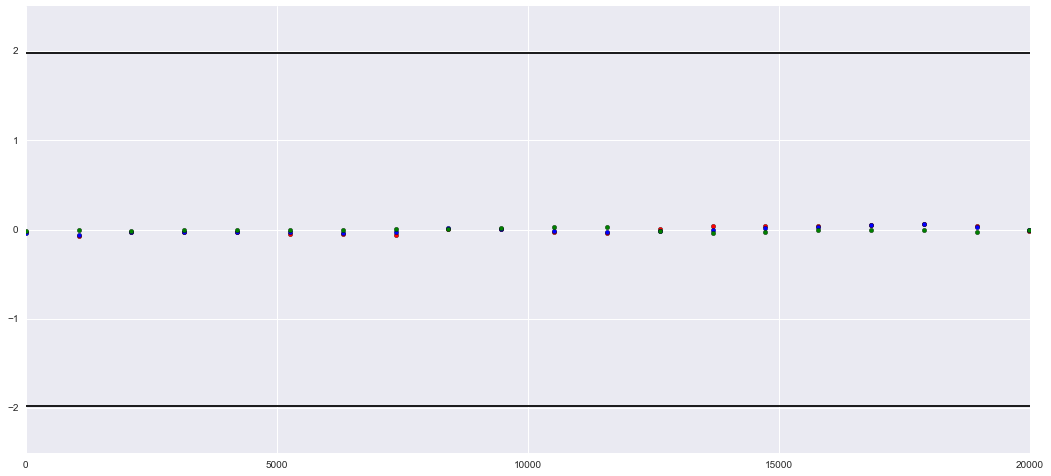

In [31]:
ge_score=pd.DataFrame(geweke(trace['gain_error']))
pe_score=pd.DataFrame(geweke(trace['phase_error']))
be_score=pd.DataFrame(geweke(trace['bias_error']))
                      
plt.scatter(ge_score[0],ge_score[1], c='r')
plt.scatter(pe_score[0],pe_score[1], c='b')
plt.scatter(be_score[0],be_score[1], c='g')
plt.axhline(-1.98, c='k')
plt.axhline(1.98, c='k')
plt.xlim(0,20000)
plt.ylim(-2.5,2.5);

#### Autocorrelation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1261c3d358>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f123bc2ea20>]], dtype=object)

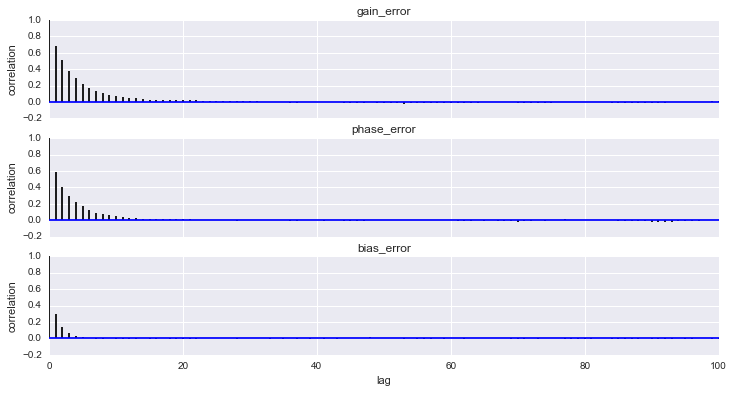

In [32]:
plots.autocorrplot(trace, varnames=['gain_error', 'phase_error', 'bias_error'])

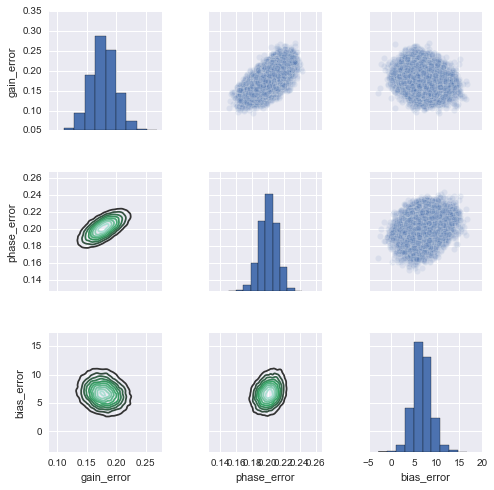

In [33]:
df = trace_to_dataframe(trace)
g = sns.PairGrid(df[['gain_error', 'phase_error', 'bias_error']])
_ = g.map_upper(plt.scatter, linewidths=1, s=40, edgecolor='w',alpha=0.1)
_ = g.map_diag(plt.hist)
_ = g.map_lower(sns.kdeplot)

We see that some autocorrelation is present between gain error and phase error. Although we can thin the trace so that it only includes every *n*th step, this is considered less desirable than just running the chain for *n* times longer. ([See Kruschke's discussion](doingbayesiandataanalysis.blogspot.com/201/11/thinning-to-reduce-autocorrelation.html)). Autocorrelation does not necessarily mean that the chain as not converged. For that, we also check the Gelman-Rubin statistic:

#### Gelman-Rubin statistic

This statistic checks for convergence. It requires multiple chains, which fiddles with the other statistics (at my skill level). And so here are the results if we specified 

```python
njobs=2
```
Bear in mind that a number close to 1 indicates convergence:

```python
gelman_rubin(trace)
```
{'bias_error': 0.9999948522506974,

 'gain_error': 1.0000930153977698,
 
 'phase_error': 1.0000543090618941}
 
We can now be reasonably sure that we can trust our result.

### Bayesian Result

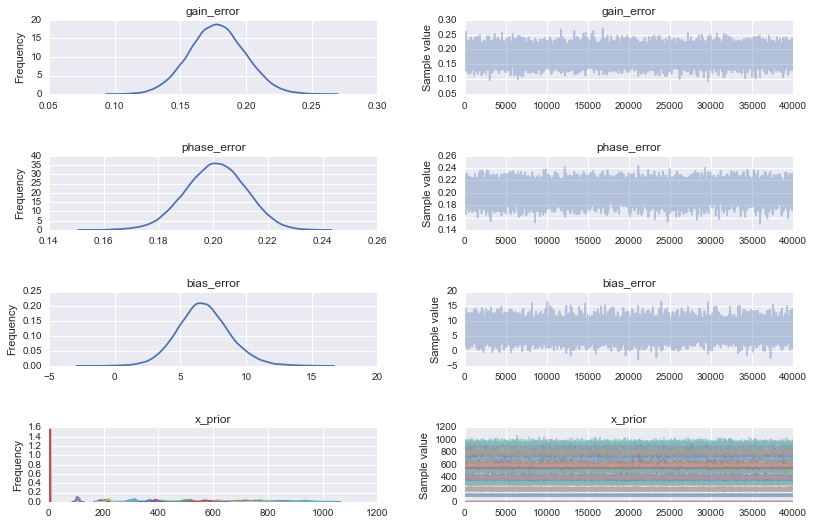

In [34]:
traceplot(trace)
plt.tight_layout();

In [35]:
summary(trace, varnames=['gain_error', 'phase_error', 'bias_error'])


gain_error:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.178            0.021            0.000            [0.135, 0.219]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.137          0.164          0.178          0.192          0.220


phase_error:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.201            0.011            0.000            [0.180, 0.223]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.179          0.194          0.201          0.208          0.222


bias_error:

  Mean             SD               MC Error         95% HPD interval
  ---------

/home/herman/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


# Overall comparison

The results above are only applicable to a specific case, depending on the random numbers generated for $X_{obs}$. What if a different random seed were used, producing a different dataset?

In order to test the overall performance of the algorithms, I wrote a batch script that would repeat the simulations for different random data sets (random seeds corresponding to the iteration number for repeatability). This script is available in the GitHub repository. Effectively, we are now comparing the performance of the algorithms over multiple data sets; a Monte Carlo of the Monte Carlo. Unfortunately, this is computationally very expensive for my Celeron laptop, and so the data set isn't as large as I would like - only one hundred runs, but enough to identify the pattern. The results are as  follows:

In [36]:
results = pd.read_csv('cal_sim_results.csv', index_col=0)
np.round(results.describe([0.025, 0.5, 0.975]), 2)

,WMAE gain,WMAE phase,WMAE bias,Bayes gain,Bayes phase,Bayes bias,OLS gain,OLS phase,OLS bias
count,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00,111.00
mean,0.38,0.09,1.07,1.35,0.12,-1.86,0.68,0.50,0.49
std,11.74,6.37,30.36,9.54,4.98,25.72,14.74,8.10,99.20
min,-25.86,-14.78,-64.22,-20.88,-11.97,-64.41,-44.90,-12.76,-289.95
2.5%,-21.61,-12.58,-55.94,-15.70,-8.77,-55.32,-25.06,-12.61,-220.96
50%,-0.26,0.50,0.25,0.88,0.11,-1.09,0.28,0.78,1.03
97.5%,24.96,9.50,49.75,18.77,10.36,42.20,29.39,17.41,171.92
max,38.51,24.30,69.94,31.64,16.24,55.85,37.26,27.03,254.94


## Gain Error

This is the 'slope' term of the equation, and we can see that the Bayesian method estimates the parameters with smaller errors and than the other methods.

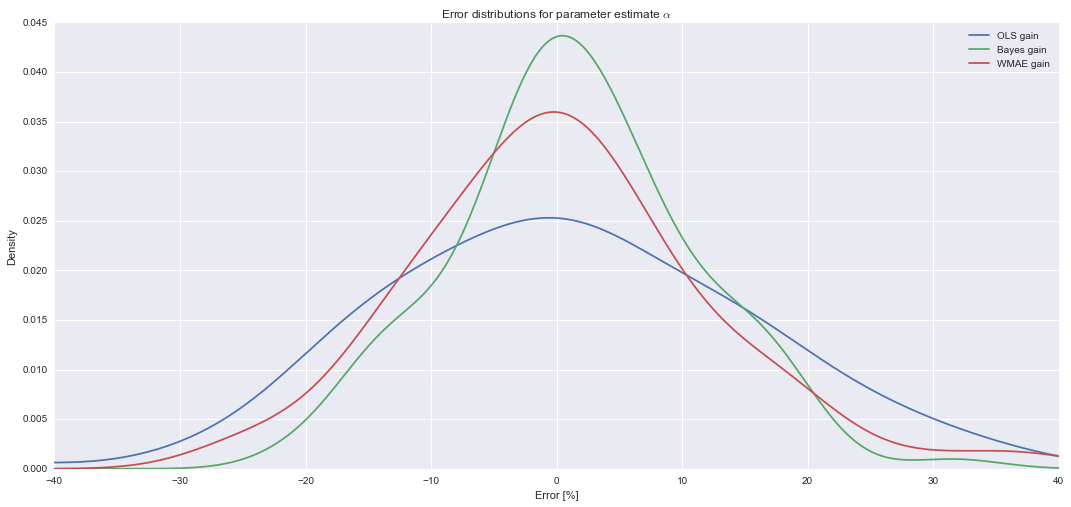

In [37]:
results[['OLS gain','Bayes gain', 'WMAE gain']].plot(kind='kde', xlim=[-40, 40])
plt.title(r'Error distributions for parameter estimate $\alpha$')
plt.xlabel('Error [%]')

## Phase Error

This is the non-linear term. Once again, the Bayesian method has a lower variance. The slight observed for WMAE may fade with a larger sample.

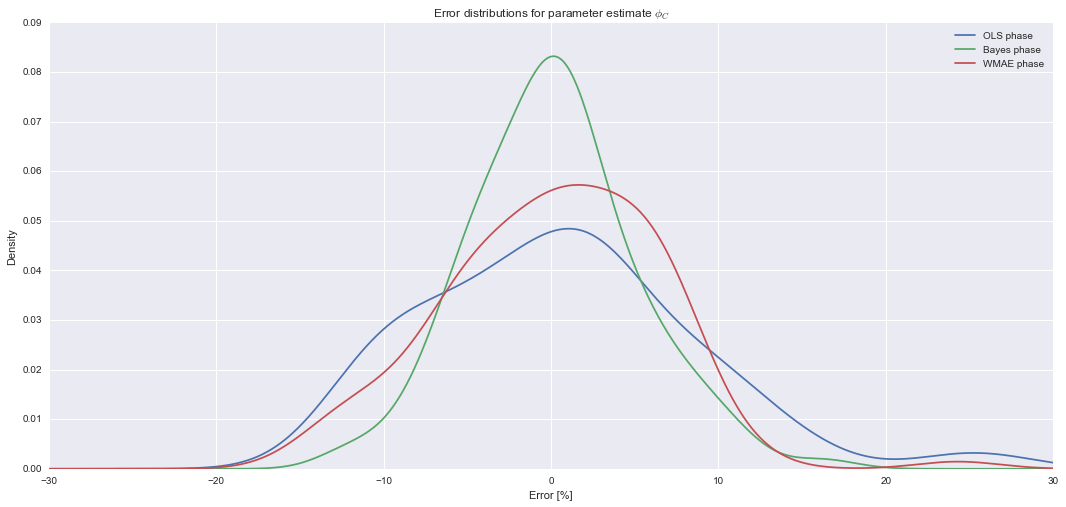

In [38]:
results[['OLS phase', 'Bayes phase', 'WMAE phase']].plot(kind='kde', xlim=[-30, 30])
plt.title(r'Error distributions for parameter estimate $\phi_{C}$')
plt.xlabel('Error [%]')

## Bias Error

We can see that for the bias (intercept) error, the WMAE does give a more accurate estimate than the Bayesian method. The question now arises, should we use the $\hat{\phi}_{WMAE}$ instead of $\hat{\phi}_{Bayesian}$? And the answer isn't a simple 'yes'. We should consider the interaction between the parameters. The other Bayesian parameters for a specific data set have been selected for a best fit with the 'erroneous' bias parameter estimate. Using a different estimate whilst keeping the other parameters the same may lead to a deterioration in the goodness of the overall fit, even if the errors on all the parameters are now smaller.

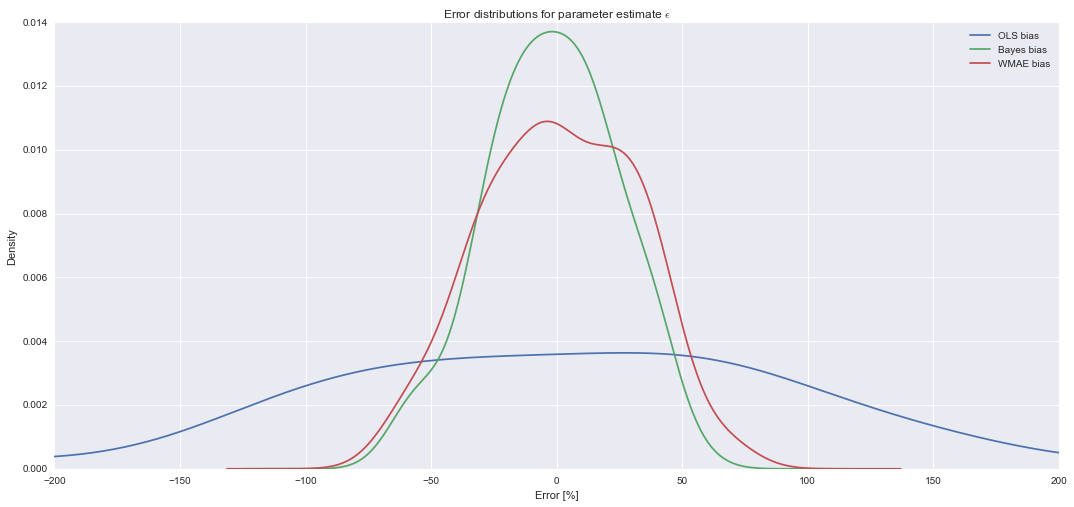

In [39]:
results[['OLS bias','Bayes bias', 'WMAE bias']].plot(kind='kde', xlim=[-200,200])
plt.xlabel('Error [%]')
plt.title(r'Error distributions for parameter estimate $\epsilon$')

# Conclusion

Measurement errors, especially errors in $X$, pose a serious problem when doing regression. However, for the case of electrical energy measurement calibration the specifics of the error generation process can be used to our advantage if we specify a Bayesian model.

The effect of measurement error can be minimised relatively effectively and quickly by using a Weighted Minimum Absolute Error (WMAE) optimization function. However, Bayesian models provide a more computationally expensive, but more accurate and comprehensive alternative estimate. In the end, the effect of measurement uncertainty on the parameter estimates can be mitigated to within a few percent of the true parameter values, eliminating attenuation bias almost completely, although mileage may vary depending on the specific data set.

# Appendix 1: Linear Regression  batch code

```python
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from pymc3 import *

a=1
b=0
RUNS=500
filename = "LinReg4.csv"
x_true = np.linspace(1, 1000, 100)
y_true = a*x_true+b
tau = np.linspace(0.001, 0.5, RUNS)
a_star = np.zeros(len(tau))
b_star = np.zeros(len(tau))
a_Bayes = np.zeros_like(a_star)
b_Bayes = np.zeros_like(b_star)
experimental_points=len(x_true)

try: # If the file of previous RUNS does exist: load results
    results = pd.read_csv(filename, index_col=0)
    start_i = np.where(results['a_star'].isnull())[0][0]
    pass
except OSError: # When the file doesn't exist
    results = pd.DataFrame(index=np.arange(0, RUNS),
                       columns=('tau', 'a_star', 'b_star', 'a_Bayes', 'b_Bayes'))

start_i = 0
for i in range(start_i, RUNS):
    print(i)    
    x_obs = x_true/np.random.normal(np.ones_like(x_true), tau[i])
    y_obs = a*x_true + b
    y_obs_LR, x_obs_LR = dmatrices('y_obs~x_obs', return_type='dataframe')
    est = LinearRegression()
    est.fit(x_obs_LR, y_obs_LR)
    a_star[i] = est.coef_[0][1]
    b_star[i] = est.intercept_[0]
    sd_x = x_obs*tau[i]**2
    
    with Model() as model:
        a_prior = StudentT('a_prior', mu=1, sd=100, nu=1)
        b_prior = StudentT('b_prior', mu=0, sd=100, nu=1)
        x_prior = Normal('x_prior', mu=x_obs, sd=sd_x, shape=experimental_points)
        mu_y = x_prior*a_prior+b_prior
        y_likelihood = StudentT('y_est', mu=mu_y, sd=5, observed=y_obs, nu=1)
        start={'a_prior': 1, 'b_prior': 0, 'x_prior': x_obs}
        trace = sample(20000, step=NUTS(), start=start)
    
    hist = pd.DataFrame()
    Bayes1=np.array([np.nan, np.nan, np.nan])
    hist['index'] = pd.Series(np.histogram(trace.a_prior, bins=75)[1])
    hist['count'] = pd.Series(np.histogram(trace.a_prior, bins=75)[0])
    halfwidth = (hist['index'][1]-hist['index'][0])/2 #added below to find centre of bin, not edge
    a_Bayes[i] = hist['index'][hist.loc[hist['count']==hist['count'].max()].index[0]]+halfwidth
    
    hist['index'] = pd.Series(np.histogram(trace.b_prior, bins=75)[1])
    hist['count'] = pd.Series(np.histogram(trace.b_prior, bins=75)[0])
    halfwidth = (hist['index'][1]-hist['index'][0])/2
    b_Bayes[i] = hist['index'][hist.loc[hist['count']==hist['count'].max()].index[0]]+halfwidth    
    
    results.loc[i] = [tau[i], a_star[i], b_star[i], a_Bayes[i], b_Bayes[i]]  
    results.to_csv(path_or_buf=filename)    
```

# Appendix 2:  Bayesian Calibration batch code

```python
# -*- coding: utf-8 -*-
# ================================= Preliminaries ============================
from pymc3 import *
import time
import theano.tensor as T
import numpy as np
import pandas as pd
import scipy.stats
import scipy

# for handling theano errors more accurately:
theano.config.exception_verbosity = 'high'  

# Parameter definition:
GAIN_ERROR = 0.2
PHASE_ERROR = 0.2
BIAS_ERROR_MEAN = 5
BIAS_ERROR_SD = BIAS_ERROR_MEAN*0.5
X_PRECISION = 0.1  # precision of calibrator at 95% confidence level
X_CONF = 1.96  # z = 1.96 is the 95% confidence level.
RUNS = 1000
filename = 'results_i7_true_err5.csv'
start_i = 0

# ================================= Functions ===============================
# Function for sum(|y*-y*(X*)| / X*)
def WMAE(params):
    [yg, yp, yb]=[params[0], params[1], params[2]]
    return np.sum((np.abs(obs.y_star-((1 + yg)*obs.x_star*np.cos(yp+obs.phi)
                   + yb)))/(obs.x_star))
                  
def x_to_y_star(x, yg, yp, ybm, ybsd, phi):
    # generate individual bias errors for every point of x, according to the
    # normal distribution with parameters ybm and ybsd
    return ((1 + yg)*x*np.cos(yp+phi) + np.random.normal(loc=ybm, scale=ybsd,
            size=x.size))
            
def OLS(params):
    [yg, yp, yb]=[params[0], params[1], params[2]]
    return np.sum((obs.y_star-((1 + yg)*obs.x_star*np.cos(yp+obs.phi)
                   + yb))**2)

# ============================ RV Setup =====================================

try: # If the file of previous RUNS does exist: load results
    results = pd.read_csv(filename, index_col=0)
    pass
except OSError: # When the file doesn't exist
    results = pd.DataFrame(index=np.arange(0, RUNS),
                       columns=('WMAE gain', 'WAME phase', 'WMAE bias',
                                'Bayes gain', 'Bayes phase', 'Bayes bias',
                                'OLS gain', 'OLS phase', 'OLS bias'))
                           
#results = pd.read_csv(filename, index_col=0)
start_time = time.clock()
for i in range(start_i, RUNS):
    run_start_time = time.clock()
    np.random.seed = i

    testpoints = pd.Series(np.arange(5, 1005, 100))  # Testpoints are the
# points at which readings are taken, i.e. where the calibrator
# is set to 5, 10, 15...
    phipoints_ones = pd.Series(np.ones_like(testpoints))
    x_star_arr = pd.concat([testpoints, testpoints, testpoints],
                           ignore_index=True)

    #x_err = np.random.normal(1, X_PRECISION/X_CONF, size=x_star_arr.size)
    # Since the distribution is symmetric, the error term can by multiplied
    # into x or x_star
    #x = x_star_arr*x_err
    x = np.random.normal(x_star_arr, x_star_arr*X_PRECISION/X_CONF)
    phi_v = pd.concat([np.pi/3*phipoints_ones, np.pi/6*phipoints_ones,
                       0*phipoints_ones], ignore_index=True)
    y_star = x_to_y_star(x, GAIN_ERROR, PHASE_ERROR,
                         BIAS_ERROR_MEAN, BIAS_ERROR_SD, phi_v)
    
    obs = pd.DataFrame({'x_star':x_star_arr, 'phi':phi_v, 'y_star':y_star,
                        'x':x})
# ================================== Minimization methods ====================

    res_WMAE = scipy.optimize.minimize(WMAE,
                                  np.array([0.0, 0.0, 0.0]),
                                  method='Powell')
    
    res_OLS = scipy.optimize.minimize(OLS, np.array([0.0, 0.0, 0.0]),
                                  method='Powell')
                                  
    WMAE_err = [(GAIN_ERROR - res_WMAE.x[0])/GAIN_ERROR*100,
                     (PHASE_ERROR - res_WMAE.x[1])/PHASE_ERROR*100, (BIAS_ERROR_MEAN -
                                                           res_WMAE.x[2]) /BIAS_ERROR_MEAN*100]

    OLS_err = [(GAIN_ERROR - res_OLS.x[0])/GAIN_ERROR*100,
                     (PHASE_ERROR - res_OLS.x[1])/PHASE_ERROR*100, (BIAS_ERROR_MEAN -
                                                           res_OLS.x[2]) /
                     BIAS_ERROR_MEAN*100]
# =================================== Bayes =================================
    shape = obs.x_star.size
    sd_y = 5 #Found to work through trial and error
    sd_x = (obs.x_star*(X_PRECISION/X_CONF)).as_matrix()
    obs_x = x_star_arr.as_matrix()
    
    with Model(verbose=0) as model:
        # Definition of priors
        gain_error = StudentT('gain_error', mu=res_WMAE.x[0], sd=2.5, nu=1)
        phase_error = StudentT('phase_error', mu=res_WMAE.x[1], sd=2.5, nu=1)
        bias_error = StudentT('bias_error', mu=res_WMAE.x[2], sd=5, nu=1)
        x_prior = Normal('x_prior', 
                         mu=obs_x,
                         sd=sd_x,
                         shape=shape)
                         
        mu_y = (1 + gain_error)*x_prior*T.cos(phase_error + obs.phi) + bias_error
        # Likelihood
        y_likelihood = StudentT('y_est',
                                nu=1,
                                mu=mu_y,
                                sd=sd_y,
                                shape=shape,
                                observed=obs.y_star)
        #start = find_MAP()
        start={'gain_error': res.x[0], 'phase_error': res.x[1], 'bias_error': res.x[2], 'x_prior': obs.x_star}
        #start={'gain_error': 0.2, 'phase_error': 0.2, 'bias_error': 5, 'x_prior': obs.x_star}

        trace = sample(20000, step=NUTS(), start=start)

    # Calculate errors    
    hist = pd.DataFrame()
    Bayes=np.array([np.nan, np.nan, np.nan])
    hist['index'] = pd.Series(np.histogram(trace.gain_error, bins=75)[1])
    hist['count'] = pd.Series(np.histogram(trace.gain_error, bins=75)[0])
    halfwidth = (hist['index'][1]-hist['index'][0])/2 #added below to find centre of bin, not edge
    Bayes[0] = hist['index'][hist.loc[hist['count']==hist['count'].max()].index[0]]+halfwidth

    hist['index'] = pd.Series(np.histogram(trace.phase_error, bins=75)[1])
    hist['count'] = pd.Series(np.histogram(trace.phase_error, bins=75)[0])
    halfwidth = (hist['index'][1]-hist['index'][0])/2
    Bayes[1] = hist['index'][hist.loc[hist['count']==hist['count'].max()].index[0]]+halfwidth

    hist['index'] = pd.Series(np.histogram(trace.bias_error, bins=75)[1])
    hist['count'] = pd.Series(np.histogram(trace.bias_error, bins=75)[0])
    halfwidth = (hist['index'][1]-hist['index'][0])/2
    Bayes[2] = hist['index'][hist.loc[hist['count']==hist['count'].max()].index[0]]+halfwidth

    Bayes_err = [(GAIN_ERROR - Bayes[0])/GAIN_ERROR*100,
              (PHASE_ERROR - Bayes[1])/PHASE_ERROR*100, (BIAS_ERROR_MEAN-Bayes[2]) /
              BIAS_ERROR_MEAN*100]
   
    results.loc[i] = [WMAE_err[0], WMAE_err[1], WMAE_err[2],
                      Bayes_err[0], Bayes_err[1], Bayes_err[2],
                      OLS_err[0], OLS_err[1], OLS_err[2]]

    results.to_csv(path_or_buf=filename)
    run_duration = time.clock()-run_start_time
    total_duration = (time.clock()-start_time)/60
    print("\n Run", i," duration:", "{:.1f}".format(run_duration), "s, total:",
          "{:.1f}".format(total_duration), "min")
```